In [2]:
import json
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib
import numpy as np
import re
from tqdm import tqdm
import json
import pandas as  pd 
import time
import pickle
import random
from pandas import DataFrame
from collections import defaultdict
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV
%matplotlib inline

%autosave 60

Autosaving every 60 seconds


In [3]:
with open("../cna_data/train_pub.json")as f:
    public = json.load(f)
with open("../cna_data/train_author.json")as f:
    Author = json.load(f)

- 创建训练集
- 选取适合的作者及其论文
- 针对某一作者、某篇论文生成特征
- 针对同名作者、同篇论文生成特征
- 特征是由作者+论文共同生成

In [4]:
negNum = 2

In [5]:
# 选取同名人数大于指定值的作者作为训练集
paperAndAuthor = []
authorPaper = {}
for name in Author:
#     print(len(name))
    if len(Author[name].keys()) > negNum:
        for person in Author[name]:
            authorPaper[person] = Author[name][person]
            for paper in Author[name][person]:
                temp = paper + '-' + person + '-' + name
#                 print(temp)
                paperAndAuthor.append(temp)
print(len(paperAndAuthor))

205416


- 查看pub文件中论文作者姓名书写方式
- 连字符
- encode('utf-8') 接 decode('utf-8')
-

In [6]:
zuozhe = set()
for artical in public:
#     print(artical)
#     authors = artical["authors"]
    for author in public[artical]["authors"]:
#         print(author)
        temp = author["name"].encode('utf-8')
        item = temp.decode('utf-8')
        if item not in zuozhe:
            zuozhe.add(item)

- 整理作者姓名
- 对于中文姓名使用 名_姓 表示
- 对于全空格分隔的名字，使用连字符将其连接
- 对于包含.和空格的名字，将. 和空格替换为_
- 对于中文名字 姓在前名在后的，将两者位置交换
- 还存在的问题：对于中文名字姓在前名在后的情况若名字中无连字符则无法将姓名颠倒

In [7]:
import re
import gc
import os
import psutil
from tqdm import tqdm
from collections import defaultdict

In [8]:
def cleanName(dirtyName):
    
    name = dirtyName.lower()
    name = name.replace('\xa0', ' ')
    name = name.replace('.', ' ')
    name = name.replace('dr.', '')
    name = name.replace('dr ', '')
    name = name.replace(' 0001', '')
    temp = name.split(' ')
    if len(temp) == 2:
        if '-' in temp[1] and '-' not in temp[0]:
            a = temp[1]
            temp[1] = temp[0]
            temp[0] = a
    k = []
    for t in temp:
        if t != '' and t != ' ':
            k.append(t)
    name = '_'.join(k)
    name = name.replace('-', '')
    return name


In [9]:
def getSample(item):
    sample = []
    paper, author, name = item.split('-')
    sample.append('-'.join([paper, author, name, '1']))

    candidateList = list(Author[name].keys())
    candidateList.remove(author)
    negPeople = random.sample(candidateList, negNum)
    for negPerson in negPeople:
        sample.append('-'.join([paper, negPerson, name, '0']))
    return sample
        

In [10]:
def entropy(dic):
    count = []
    total = 0
    ans = 0
    for item in dic:
        count.append(dic[item])
        total += dic[item]
    prob = [item/total for item in count]
    for item in prob:
        ans += -1 * item * round(np.log(item), 6)
    return ans

In [11]:
def cleanYear(dic):
    count = []
    largest = 0
    smallest = 3000
    err = 0
    ans = defaultdict(int)
    for item in dic:
        if item == '' or item > 2019 or item < 1950 :
            err += dic[item]
        else:
            count.append(dic[item])
            ans[item] = dic[item]
            if item > largest:
                largest = item
            if item < smallest:
                smallest = item
    mean = np.mean(count)
    if smallest < largest:
        add = np.random.randint(smallest, largest, err)
    else:
        add = [smallest] * err
    for data in add:
        ans[data] += 1
    count = []
    for item in ans:
        count.append(ans[item])
    mean = np.mean(count)
    for item in ans:
        ans[item] = 1/(1 + np.abs(mean - ans[item]))
    
    return ans

In [12]:
def getFeature(item):
    stopWord = ['', 'a', 'an', ':', 'the', '.', ',', '\n', '(', ')', ]
    paperId, authorId, _, label = item.split('-')
    
    paperInfo = public[paperId]
    
    title = paperInfo["title"]
    authors = paperInfo["authors"]
    venue = paperInfo["venue"]
    year = paperInfo.get("year", 0)
    keyword = paperInfo.get("keywords", "")
    if keyword == None:
        keyword = [""]
    abstract = paperInfo.get("abstract", "")
    if abstract == None:
        abstract = ""
    #这里不对待查询作者进行删除
    #对待查询论文进行预处理，获取其相关特征
    #特征包括titleLength、words、coauthors、coauthorsLength、coauthorsDiffLength、
    #        orgs、orgsDiffLength、venu、year、keywords、abstractLength
    #题目长度、题目词频
    titles = title.split()
    titleLength = 0
    words = defaultdict(int)
    for item in titles:
        if item.lower() not in stopWord:
            titleLength += 1
            words[item.lower()] += 1
            
    #合作者个数、频率
    coauthors = defaultdict(int)
    coauthorsLength = 0
    for item in authors:
        if item["name"] != '':
            coauthors[cleanName(item["name"])] += 1
            coauthorsLength += 1
    coauthorsDiffLength = len(coauthors)
    
    #合作机构频率
    orgs = defaultdict(int)
    for item in authors:
        orgs[item.get("org", "").lower()] += 1
    orgsDiffLength = len(orgs)
            
    #发表年份可能不存在
            
    #关键词词频
    keywords = defaultdict(int)
    for item in keyword:
        if item != '':
            keywords[item.lower()] += 1
    
    #摘要长度、词频
    abstractLength = 0
    abstracts = abstract.split()
    for item in abstracts:
        if item not in stopWord:
            abstractLength += 1
            words[item.lower()] += 1
    
    
    relatedTitleLength = 0               #题目平均长度 1
    relatedCoauthorLength = 0            #合作者数量1
    relatedCoauthorDiffLength = 0        #合作者人数1
    relatedOrgsDiffLength = 0            #合作机构个数1
    relatedAbstractLength = 0            #摘要长度
    relatedCoauthors = defaultdict(int)  #合作者1
    relatedOrgs = defaultdict(int)       #合作机构1
    relatedVenue = defaultdict(int)      #发表期刊1
    relatedYear = defaultdict(int)       #发表年份1
    relatedKeyword = defaultdict(int)    #关键词1
    relatedWords = defaultdict(int)      #题目、摘要出现词
    relatedOrgEntropy = 0
    
    relatedPapers = authorPaper[authorId]
    #去除待分类论文
    if paperId in relatedPapers:
        relatedPapers.remove(paperId)
    for relatedPaper in relatedPapers:
        relatedPaperInfo = public[relatedPaper]
        
        tempAuthors = relatedPaperInfo["authors"]
        tempOrgs = defaultdict(int)
        for tempName in tempAuthors:
            #机构、合作者频率
            #合作者数量
            relatedOrgs[tempName.get("org", "")] += 1
            relatedCoauthors[cleanName(tempName["name"])] += 1
            tempOrgs[tempName.get("org", "")] += 1
            relatedCoauthorLength += 1
        #机构平均散度
        relatedOrgEntropy += entropy(tempOrgs)
        #年份
        relatedYear[relatedPaperInfo.get("year", 0)] += 1
        #期刊
        relatedVenue[relatedPaperInfo.get("venue", "none")] += 1
        #关键词
        for item in relatedPaperInfo.get("keywords", ""):
            if item != '':
                relatedKeyword[item.lower()] += 1
        #题目长度
        tempTitle = relatedPaperInfo["title"].split()
        for item in tempTitle:
            if item not in stopWord:
                relatedTitleLength += 1
                relatedWords[item.lower()] += 1
        #摘要
        tempAbstracts = relatedPaperInfo.get("abstract", " ")
        if tempAbstracts == None:
            tempAbstracts = ""
        tempAbstracts = tempAbstracts.split()
        
        for item in tempAbstracts:
            if item not in stopWord:
                relatedAbstractLength += 1
                relatedWords[item.lower()] += 1
        
    relatedTitleLengthAve = relatedTitleLength/(len(relatedPapers) + 1)
    relatedCoauthorLengthAve = relatedCoauthorLength/(len(relatedPapers) + 1)
    relatedAbstractLengthAve = relatedAbstractLength/(len(relatedPapers) + 1)
    relatedCoauthorDiffLength = len(relatedCoauthors)
    relatedOrgsDiffLength = len(relatedOrgs)
    relatedOrgsDiffLengthAve = len(relatedOrgs)/(len(relatedPapers) + 1)
    relatedOrgEntropyAve = relatedOrgEntropy/(len(relatedPapers) + 1)
    #根据待查询论文与待查询作者的相关信息生成特征
    #1、题目长度 待查询论文题目长度/待查询作者论文题目平均长度
    scoreTitle = titleLength/(relatedTitleLengthAve + 1)
    
    #2、合作者相关
    # -1重合的合作者数
    # -2待查询论文的合作者数/待查询作者的平均合作者数(relatedCoauthorLengthAve)
    # -3重合的合作者数/待查询论文的合作者数(coauthorsLength)
    # -4重合的合作者数/待查询作者的合作者数(relatedCoauthorDiffLength)
    # -5重合的合作者的总合作次数
    # -6重合的合作者的总合作次数/所有合作者的总合作次数
    
    relatedCoauthorsSet = set(relatedCoauthors.keys())
    coauthorsSet = set(coauthors.keys())
    scoreAuthor1 = len(relatedCoauthorsSet & coauthorsSet)
    scoreAuthor2 = coauthorsLength /(relatedCoauthorLengthAve + 1)
    scoreAuthor3 = scoreAuthor1 /(coauthorsLength + 1)
    scoreAuthor4 = scoreAuthor1 /(relatedCoauthorDiffLength + 1)
    scoreAuthor5 = 0
    for item in coauthorsSet:
        scoreAuthor5 += relatedCoauthors[item]
    scoreAuthor6 = scoreAuthor5/(relatedCoauthorLength + 1)
    
    #3、期刊相关
    # -1 重合期刊的发表次数
    # -2 重合期刊的发表次数/总发表期刊次数
    
    scoreVenue1 = relatedVenue.get(venue, 0)
    temp = 0
    for item in relatedVenue:
        temp += relatedVenue[item]
    scoreVenue2 = scoreVenue1/(temp + 1)
    
    #4、合作机构相关
    # -1 待查询论文合作机构(orgsDiffLength)
    # -2 待查询论文合作机构/待查询作者平均合作机构
    # -3 待查询论文合作机构总合作次数
    # -4 待查询论文合作机构总合作次数/待查询作者所有合作机构总合作次数
    # -5 待查询论文合作机构散度
    # -6 待查询论文合作机构散度/待查询作者所有合作机构平均散度
    scoreOrg1 = orgsDiffLength
    scoreOrg2 = orgsDiffLength/(relatedOrgsDiffLengthAve + 1)
    scoreOrg3 = 0
    for item in orgs:
        scoreOrg3 += relatedOrgs[item]
    temp = 0
    for item in relatedOrgs:
        temp += relatedOrgs[item]
    scoreOrg4 = scoreOrg3/(temp + 1)
    scoreOrg5 = entropy(orgs)
    scoreOrg6 = scoreOrg5/(relatedOrgEntropyAve + 1)
    
    #5、发表时间
    #我们认为同一作者不同年份发表数量均匀
    #则对偏离平均发表数量的年份做惩罚
    
    if year == 0:
        scoreYear = 0
    else:
        scoreYear = cleanYear(relatedYear)[year]
        
    #6、关键词相关
    # -1 重合关键词总次数
    # -2 总关键词次数
    
    originKeywords = set(keywords.keys())
    relatedKeywords = set(relatedKeyword.keys())
    scoreKeyword1 = len(originKeywords & relatedKeywords)
    scoreKeyword2 = 0
    for item in relatedKeyword:
        scoreKeyword2 += relatedKeyword[item]
    
    
    #7、摘要相关
    # -1 待查询论文摘要长度/平均摘要长度
    # -2 待查询论文摘要关键词重合个数
    # -3 关键词重合总次数
    # -4 关键词重合总次数/总关键词出现次数
    
    scoreAbstract1 = abstractLength/(relatedAbstractLengthAve + 1)
    originWord = set(words.keys())
    relatedWord = set(relatedWords.keys())
    scoreAbstract2 = len(originWord & relatedWord)
    scoreAbstract3 = 0
    for item in words:
        scoreAbstract3 += relatedWords.get(item, 0)
    temp = 0
    for item in relatedWords:
        temp += relatedWords[item]
    scoreAbstract4 = scoreAbstract3/(temp + 1)
    
    # 所有特征
    # 1、scoreTitle
    # 2、scoreAuthor1
    # 3、scoreAuthor2 
    # 4、scoreAuthor3
    # 5、scoreAuthor4
    # 6、scoreAuthor5
    # 7、scoreAuthor6
    # 8、scoreVenue1
    # 9、scoreVenue2 
    # 10、scoreOrg1
    # 11、scoreOrg2
    # 12、scoreOrg3 
    # 13、scoreOrg4
    # 14、scoreOrg5
    # 15、scoreOrg6 
    # 16、scoreYear
    # 17、scoreKeyword1
    # 18、scoreKeyword2 
    # 19、scoreAbstract1
    # 10、scoreAbstract2
    # 21、scoreAbstract3 
    # 21、scoreAbstract4
    
    feature = [round(scoreTitle, 6),
               round(scoreAuthor1, 6),
               round(scoreAuthor2, 6),
               round(scoreAuthor3, 6),
               round(scoreAuthor4, 6),
               round(scoreAuthor5, 6),
               round(scoreAuthor6, 6),
               round(scoreVenue1, 6),
               round(scoreVenue2, 6),
               round(scoreOrg1, 6),
               round(scoreOrg2, 6),
               round(scoreOrg3, 6),
               round(scoreOrg4, 6),
               round(scoreOrg5, 6),
               round(scoreOrg6, 6),
               round(scoreYear, 6),
               round(scoreKeyword1, 6),
               round(scoreKeyword2, 6),
               round(scoreAbstract1, 6),
               round(scoreAbstract2, 6),
               round(scoreAbstract3, 6),
               round(scoreAbstract4, 6)
              ]
    return [feature, label]   

In [13]:
a = list(Author[name].keys())
print(a)

['vwt9Wd81', 'MLEuzS1T', 'xOEKHNxv', 'Ms4yXx88', 'VosVgGWX', 'H7pPNJ9H', 'Izy4g5GJ', 'KCYgj45o', 'QgxWVd6S', '7mR9sXDN', '3qn5CxG9']


In [14]:
pickleText = []
trainSet = paperAndAuthor
posAndNegSample = []
random.shuffle(trainSet)
for item in trainSet:
    posAndNegSample.extend(getSample(item))

result = []
for item in tqdm(posAndNegSample):
    result.append(getFeature(item))
pickleText.extend(result)

  0%|          | 25/616248 [00:00<41:17, 248.75it/s]/home/zuijiang/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zuijiang/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 616248/616248 [38:12<00:00, 268.83it/s]  


In [15]:
sample = []
for item in tqdm(pickleText):
    f, l = item
    l = int(l)
    f.append(l)
    sample.append(f)

100%|██████████| 616248/616248 [00:00<00:00, 1802247.75it/s]


In [16]:
test = np.array(sample)
print(test.shape)

(616248, 23)


In [17]:
from pandas import DataFrame
import pandas as pd

In [18]:
random.shuffle(test)
features = DataFrame(test, columns=["Title", "Author1", "Author2", "Author3",
                                   "Author4", "Author5", "Author6", "Venue1",
                                   "Venue2", "Org1", "Org2", "Org3",
                                   "Org4", "Org5", "Org6", "Year",
                                   "Keyword1", "Keyword2", "Abstract1", "Abstract2",
                                   "Abstract3", "Abstract4",
                                   "label",
                                   ])

In [19]:
tempFeature = (features - features.mean())/features.std()
labelSample = features["label"]
col = [item for item in features.columns if item != "label"]
featureSample = features[col]
tempFeature = (featureSample - featureSample.mean())/featureSample.std()

In [20]:
np.array(tempFeature).shape

(616248, 22)

In [21]:
features.mean()

Title           1.923687
Author1         8.532953
Author2         6.122245
Author3         0.282686
Author4         0.091565
Author5       863.847628
Author6         0.195122
Venue1          1.611264
Venue2          0.030789
Org1            2.996878
Org2            1.536680
Org3          576.058392
Org4            0.092138
Org5            0.391260
Org6            0.305145
Year            0.214444
Keyword1        0.364196
Keyword2      177.177828
Abstract1      15.909005
Abstract2      18.852115
Abstract3    1041.499956
Abstract4       0.168549
label           0.333707
dtype: float64

In [22]:
with open("../cna_data/whole_author_profile_pub.json")as f:
    wholePublic = json.load(f)
with open("../cna_data/cna_test_pub.json")as f:
    testPublic = json.load(f)
with open("../cna_data/whole_author_profile.json")as f:
    authorPaper = json.load(f)
with open("../cna_data/cna_test_unass_competition.json")as f:
    testData = json.load(f)
    
label = np.array(labelSample)
feature = np.array(tempFeature)
means = np.array(features.mean().tolist()[:-1])
stds = np.array(features.std().tolist()[:-1])
features = feature
labels = label
mean = means
std = stds

xSample = features.tolist()
ySample = labels.tolist()

In [23]:
trainNum = 500000
xTrain = xSample[:trainNum]
yTrain = ySample[:trainNum]
xTest = xSample[trainNum:]
yTest = ySample[trainNum:]
dtrain = xgb.DMatrix(xTrain, label=yTrain)
dtest = xgb.DMatrix(xTest, label=yTest)

def getFeature(item):
    stopWord = ['', 'a', 'an', ':', 'the', '.', ',', '\n', '(', ')', ]
    paperId, authorId = item.split('-')
    
    paperInfo = testPublic[paperId]
    
    title = paperInfo["title"]
    authors = paperInfo["authors"]
    venue = paperInfo["venue"]
    year = paperInfo.get("year", 0)
    keyword = paperInfo.get("keywords", "")
    if keyword == None:
        keyword = [""]
    abstract = paperInfo.get("abstract", "")
    if abstract == None:
        abstract = ""
    #这里不对待查询作者进行删除
    #对待查询论文进行预处理，获取其相关特征
    #特征包括titleLength、words、coauthors、coauthorsLength、coauthorsDiffLength、
    #        orgs、orgsDiffLength、venu、year、keywords、abstractLength
    #题目长度、题目词频
    titles = title.split()
    titleLength = 0
    words = defaultdict(int)
    for item in titles:
        if item.lower() not in stopWord:
            titleLength += 1
            words[item.lower()] += 1
            
    #合作者个数、频率
    coauthors = defaultdict(int)
    coauthorsLength = 0
    for item in authors:
        if item["name"] != '':
            coauthors[cleanName(item["name"])] += 1
            coauthorsLength += 1
    coauthorsDiffLength = len(coauthors)
    
    #合作机构频率
    orgs = defaultdict(int)
    for item in authors:
        orgs[item.get("org", "").lower()] += 1
    orgsDiffLength = len(orgs)
            
    #发表年份可能不存在
            
    #关键词词频
    keywords = defaultdict(int)
    for item in keyword:
        if item != '':
            keywords[item.lower()] += 1
    
    #摘要长度、词频
    abstractLength = 0
    abstracts = abstract.split()
    for item in abstracts:
        if item not in stopWord:
            abstractLength += 1
            words[item.lower()] += 1
    
    
    relatedTitleLength = 0               #题目平均长度 1
    relatedCoauthorLength = 0            #合作者数量1
    relatedCoauthorDiffLength = 0        #合作者人数1
    relatedOrgsDiffLength = 0            #合作机构个数1
    relatedAbstractLength = 0            #摘要长度
    relatedCoauthors = defaultdict(int)  #合作者1
    relatedOrgs = defaultdict(int)       #合作机构1
    relatedVenue = defaultdict(int)      #发表期刊1
    relatedYear = defaultdict(int)       #发表年份1
    relatedKeyword = defaultdict(int)    #关键词1
    relatedWords = defaultdict(int)      #题目、摘要出现词
    relatedOrgEntropy = 0
    
    relatedPapers = authorPaper[authorId]["papers"]
    #去除待分类论文
    if paperId in relatedPapers:
        relatedPapers.remove(paperId)
    for relatedPaper in relatedPapers:
#         print(relatedPaper)
        relatedPaperInfo = wholePublic[relatedPaper]
        
        tempAuthors = relatedPaperInfo["authors"]
        tempOrgs = defaultdict(int)
        for tempName in tempAuthors:
            #机构、合作者频率
            #合作者数量
            relatedOrgs[tempName.get("org", "")] += 1
            relatedCoauthors[cleanName(tempName["name"])] += 1
            tempOrgs[tempName.get("org", "")] += 1
            relatedCoauthorLength += 1
        #机构平均散度
        relatedOrgEntropy += entropy(tempOrgs)
        #年份
        relatedYear[relatedPaperInfo.get("year", 0)] += 1
        #期刊
        relatedVenue[relatedPaperInfo.get("venue", "none")] += 1
        #关键词
        for item in relatedPaperInfo.get("keywords", ""):
            if item != '':
                relatedKeyword[item.lower()] += 1
        #题目长度
        tempTitle = relatedPaperInfo["title"].split()
        for item in tempTitle:
            if item not in stopWord:
                relatedTitleLength += 1
                relatedWords[item.lower()] += 1
        #摘要
        tempAbstracts = relatedPaperInfo.get("abstract", " ")
        if tempAbstracts == None:
            tempAbstracts = ""
        tempAbstracts = tempAbstracts.split()
        
        for item in tempAbstracts:
            if item not in stopWord:
                relatedAbstractLength += 1
                relatedWords[item.lower()] += 1
        
    relatedTitleLengthAve = relatedTitleLength/(len(relatedPapers) + 1)
    relatedCoauthorLengthAve = relatedCoauthorLength/(len(relatedPapers) + 1)
    relatedAbstractLengthAve = relatedAbstractLength/(len(relatedPapers) + 1)
    relatedCoauthorDiffLength = len(relatedCoauthors)
    relatedOrgsDiffLength = len(relatedOrgs)
    relatedOrgsDiffLengthAve = len(relatedOrgs)/(len(relatedPapers) + 1)
    relatedOrgEntropyAve = relatedOrgEntropy/(len(relatedPapers) + 1)
    #根据待查询论文与待查询作者的相关信息生成特征
    #1、题目长度 待查询论文题目长度/待查询作者论文题目平均长度
    scoreTitle = titleLength/(relatedTitleLengthAve + 1)
    
    #2、合作者相关
    # -1重合的合作者数
    # -2待查询论文的合作者数/待查询作者的平均合作者数(relatedCoauthorLengthAve)
    # -3重合的合作者数/待查询论文的合作者数(coauthorsLength)
    # -4重合的合作者数/待查询作者的合作者数(relatedCoauthorDiffLength)
    # -5重合的合作者的总合作次数
    # -6重合的合作者的总合作次数/所有合作者的总合作次数
    
    relatedCoauthorsSet = set(relatedCoauthors.keys())
    coauthorsSet = set(coauthors.keys())
    scoreAuthor1 = len(relatedCoauthorsSet & coauthorsSet)
    scoreAuthor2 = coauthorsLength /(relatedCoauthorLengthAve + 1)
    scoreAuthor3 = scoreAuthor1 /(coauthorsLength + 1)
    scoreAuthor4 = scoreAuthor1 /(relatedCoauthorDiffLength + 1)
    scoreAuthor5 = 0
    for item in coauthorsSet:
        scoreAuthor5 += relatedCoauthors[item]
    scoreAuthor6 = scoreAuthor5/(relatedCoauthorLength + 1)
    
    #3、期刊相关
    # -1 重合期刊的发表次数
    # -2 重合期刊的发表次数/总发表期刊次数
    
    scoreVenue1 = relatedVenue.get(venue, 0)
    temp = 0
    for item in relatedVenue:
        temp += relatedVenue[item]
    scoreVenue2 = scoreVenue1/(temp + 1)
    
    #4、合作机构相关
    # -1 待查询论文合作机构(orgsDiffLength)
    # -2 待查询论文合作机构/待查询作者平均合作机构
    # -3 待查询论文合作机构总合作次数
    # -4 待查询论文合作机构总合作次数/待查询作者所有合作机构总合作次数
    # -5 待查询论文合作机构散度
    # -6 待查询论文合作机构散度/待查询作者所有合作机构平均散度
    scoreOrg1 = orgsDiffLength
    scoreOrg2 = orgsDiffLength/(relatedOrgsDiffLengthAve + 1)
    scoreOrg3 = 0
    for item in orgs:
        scoreOrg3 += relatedOrgs[item]
    temp = 0
    for item in relatedOrgs:
        temp += relatedOrgs[item]
    scoreOrg4 = scoreOrg3/(temp + 1)
    scoreOrg5 = entropy(orgs)
    scoreOrg6 = scoreOrg5/(relatedOrgEntropyAve + 1)
    
    #5、发表时间
    #我们认为同一作者不同年份发表数量均匀
    #则对偏离平均发表数量的年份做惩罚
    
    if year == 0:
        scoreYear = 0
    else:
        scoreYear = cleanYear(relatedYear)[year]
        
    #6、关键词相关
    # -1 重合关键词总次数
    # -2 总关键词次数
    
    originKeywords = set(keywords.keys())
    relatedKeywords = set(relatedKeyword.keys())
    scoreKeyword1 = len(originKeywords & relatedKeywords)
    scoreKeyword2 = 0
    for item in relatedKeyword:
        scoreKeyword2 += relatedKeyword[item]
    
    
    #7、摘要相关
    # -1 待查询论文摘要长度/平均摘要长度
    # -2 待查询论文摘要关键词重合个数
    # -3 关键词重合总次数
    # -4 关键词重合总次数/总关键词出现次数
    
    scoreAbstract1 = abstractLength/(relatedAbstractLengthAve + 1)
    originWord = set(words.keys())
    relatedWord = set(relatedWords.keys())
    scoreAbstract2 = len(originWord & relatedWord)
    scoreAbstract3 = 0
    for item in words:
        scoreAbstract3 += relatedWords.get(item, 0)
    temp = 0
    for item in relatedWords:
        temp += relatedWords[item]
    scoreAbstract4 = scoreAbstract3/(temp + 1)
    
    # 所有特征
    # 1、scoreTitle
    # 2、scoreAuthor1
    # 3、scoreAuthor2 
    # 4、scoreAuthor3
    # 5、scoreAuthor4
    # 6、scoreAuthor5
    # 7、scoreAuthor6
    # 8、scoreVenue1
    # 9、scoreVenue2 
    # 10、scoreOrg1
    # 11、scoreOrg2
    # 12、scoreOrg3 
    # 13、scoreOrg4
    # 14、scoreOrg5
    # 15、scoreOrg6 
    # 16、scoreYear
    # 17、scoreKeyword1
    # 18、scoreKeyword2 
    # 19、scoreAbstract1
    # 10、scoreAbstract2
    # 21、scoreAbstract3 
    # 21、scoreAbstract4
    
    feature = [round(scoreTitle, 6),
               round(scoreAuthor1, 6),
               round(scoreAuthor2, 6),
               round(scoreAuthor3, 6),
               round(scoreAuthor4, 6),
               round(scoreAuthor5, 6),
               round(scoreAuthor6, 6),
               round(scoreVenue1, 6),
               round(scoreVenue2, 6),
               round(scoreOrg1, 6),
               round(scoreOrg2, 6),
               round(scoreOrg3, 6),
               round(scoreOrg4, 6),
               round(scoreOrg5, 6),
               round(scoreOrg6, 6),
               round(scoreYear, 6),
               round(scoreKeyword1, 6),
               round(scoreKeyword2, 6),
               round(scoreAbstract1, 6),
               round(scoreAbstract2, 6),
               round(scoreAbstract3, 6),
               round(scoreAbstract4, 6)
              ]
    return feature 

authorData = defaultdict(list)
for item in authorPaper:
    name = cleanName(authorPaper[item]["name"])
    authorData[name].append(item)
    

In [24]:
rf = RandomForestClassifier(
                            n_estimators=1000,
                            criterion='entropy',
                            max_depth=9,
                            bootstrap=True,
                            random_state=0,
                            warm_start=False,
                            class_weight=None,
                            n_jobs=10,
                            min_impurity_decrease=0.1
                            )
rf.fit(xTrain, yTrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=10, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
randomforest = rf.predict_proba(xTest)
train_predictions6 = np.argmax(randomforest, 1)
y_train = dtest.get_label() #值为输入数据的第一行
train_accuracy = accuracy_score(y_train, train_predictions6)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Train Accuary: 92.22%


<BarContainer object of 22 artists>

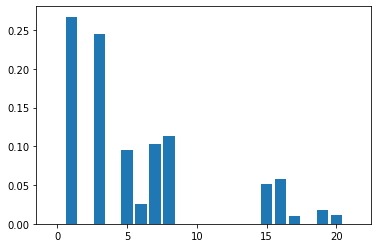

In [34]:
plt.bar(range(len(rf.feature_importances_)),(rf.feature_importances_))

In [26]:
result_dict = defaultdict(list)
total = 0
for item in tqdm(testData):
    paperId, index = item.split('-')
    paperInfo = testPublic[paperId]
    name = paperInfo["authors"]
    name = (cleanName(name[int(index)]["name"]))
    if name == 'l_deng':
        name = 'li_deng'
    if name == 'osamu':
        name = 'osamu_watanabe'
    if name == 'jun':
        name = 'jun_yang'
    if name == 'bo':
        name = 'bo_li'
    if name == 'b_liu':
        name = 'bin_liu'
    if name == 'lin':
        name = 'lin_he'
    if name == 'fei':
        name = 'fei_wei'
    if name == 'liu,_ling':
        name = 'ling_liu'
    if name == 'xie_d':
        name = 'dan_xie'
    if name == 'k_zhou':
        name = 'kun_zhou'
    if name == 'hui':
        name = 'hui_zhang'
    if name == 'hang':
        name = 'hang_li'
    if name == 'jianping':
        name = 'jianping_ding'
    if name == 'jinghong':
        name = 'jinghong_li'
    if name == 'jianfang':
        name = 'jianfang_wang'
    if name in authorData.keys():
        candidate = authorData[name]
    else:
        temp = name.split('_')
        if len(temp) == 2:
            a = temp[1]
            temp[1] = temp[0]
            temp[0] = a
        name = '_'.join(temp) 
        if name in authorData.keys():
            candidate = authorData[name]
        else:
            candidate = []
    
    classifySet = []
    for personId in candidate:
        exam = paperId + '-' + personId 
        temp = (getFeature(exam) - mean)/std
        classifySet.append(temp.tolist())
    if classifySet == []:
        continue
    prob = rf.predict_proba((classifySet))[:, 1]
    rank = np.argsort(-np.array(prob))

    result_dict[candidate[rank[0]]].append((paperId, np.array(prob)[rank[0]]))

100%|██████████| 9650/9650 [37:56<00:00,  4.24it/s]  


In [27]:
result = defaultdict(list)
threshold = 0.076
num = 0
for items in result_dict:
    for item in result_dict[items]:
        paperId, prob = item
        if prob >= threshold:
            result[items].append(paperId)
        else:
            num += 1
print(num)

0


In [29]:
with open("./result.json", 'w') as files:
    json.dump(result, files, indent = 4)